In [1]:
# Pranav Venkatesh - pranavmvp@gmail.com - 9003119787
# Aiotize Internship Task 2 - Crowd Density Estimator (Object Detection)

In [18]:
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.patches as pathes
%matplotlib inline

In [3]:
IMAGE_PATH = 'test4.jpg'

In [4]:
from darknet import Darknet

In [5]:
#!wget https://pjreddie.com/media/files/yolov3.weights

In [6]:
cfg_file = 'yolov3.cfg'
weight_file = 'yolov3.weights'

In [7]:
Model = Darknet(cfg_file)

# Load the pre-trained weights
Model.load_weights(weight_file)

In [8]:
Model.print_network()


layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

In [9]:
#NMS
def IOU_AREA(box1, box2):
    
    # Get height and width 
    wid_b1 = box1[2]
    ht_b1 = box1[3]
    wid_b2 = box2[2]
    ht_b2 = box2[3]
    
    # Get area of given 2 boxes
    area_b1 = wid_b1 * ht_b1
    area_b2 = wid_b2 * ht_b2
    
    # Calculating vertical edges
    inner = min(box1[0] - wid_b1/2.0, box2[0] - wid_b2/2.0)
    outer = max(box1[0] + wid_b1/2.0, box2[0] + wid_b2/2.0)
    
    # Subtract to get width of union
    UNION_WIDTH = outer - inner
    
    #Calculating horizontal edges
    inner = min(box1[1] - ht_b1/2.0, box2[1] - ht_b2/2.0)
    outer = max(box1[1] + ht_b1/2.0, box2[1] + ht_b2/2.0)
    
    # Subtract to get length of union
    UNION_HEIGHT = outer - inner
    
    # Get height and width of intersection of given boxes
    INTERSECTION_WIDTH = wid_b1 + wid_b2 - UNION_WIDTH
    INTERNSECTION_HEIGHT = ht_b1 + ht_b2 - UNION_HEIGHT
    
    # Condition to check no-overlap (IOU = 0)
    if INTERNSECTION_HEIGHT <=0 or INTERSECTION_WIDTH <=0:
        return 0.0
    
    #Else calculate area of both intersection and union
    INTERSECTION_AREA = INTERSECTION_WIDTH * INTERNSECTION_HEIGHT
    UNION_AREA = UNION_HEIGHT * UNION_WIDTH
    
    #Calculate and return Intersection-over-Union
    IOU = INTERSECTION_AREA / UNION_AREA
    
    return IOU

In [10]:
def Non_Maximal_Supression(boxes,Threshold):
    
    # Get total number of bounding boxes
    L = len(boxes)
    
    # Do nothing
    if(L == 0):
        return 0
    
    # PyTorch sensor to calculate confidence 
    Confidence = torch.zeros(L)
    
    # Get confidence of each box
    for i in range(L):
        Confidence[i] = boxes[i][4]
    
    # Sort according to confidence (HIGH TO LOW)
    _,sortIds = torch.sort(Confidence, descending = True)
    
    # List for best boxes
    get_best_bound = []
    
    # NMS
    for i in range(L):
        
        # Box with highest confidence 
        Ibox = boxes[sortIds[i]]
        
        # Check if confidence > 0
        if Ibox[4] > 0:
            get_best_bound.append(Ibox) # Append to best list
            
            # Compare with rest of boxes (each Jbox) and calculate IoU with 
            # respect to Ibox
            for j in range(i+1, L):
                Jbox = boxes[sortIds[j]]
                
                # If IoU of Ibox,Jbox is > given threshold
                # Make confidence of Jbox as zero
                if IOU_AREA(Ibox,Jbox) > Threshold:
                    Jbox[4] = 0
    
    return get_best_bound

In [11]:
def Detection(Model, Image, IOU_Threshold, NMS_Threshold):
    
    Model.eval() # Setting to eval mode
    
    # Convert Image from Numpy array -> PyTorch Tensor, and reshape
    Image = torch.from_numpy(Image.transpose(2,0,1)).float().div(255.0).unsqueeze(0)
    
    # All modelled bounding boxes with values < given Threshold are removed.
    Initial_Boxes = Model(Image,NMS_Threshold)
    
    # Return_Boxes list contains the boxes returned by DarkNet CNN
    # List of best boxes
    Return_Boxes = Initial_Boxes[0][0] + Initial_Boxes[1][0] + Initial_Boxes[2][0]
    
    # Out of the best boxes, all boxes with IOU > given threshold are removed.
    Return_Boxes = Non_Maximal_Supression(Return_Boxes, IOU_Threshold)
    
    # Print no. of boxes, or objects.
    print('Total Objects : ',len(Return_Boxes))
    
    return Return_Boxes

In [12]:
def print_objects(Boxes, Classes):    
    total_humans = 0
    # print('Objects Found and Confidence Level:\n')
    L = len(Boxes)
    for i in range(L):
        I_box = Boxes[i]
        if len(I_box) >= 7 and Classes:
            # Confidence = I_box[5]
            Id = I_box[6]
            if(Classes[Id]=='person'):
                total_humans+=1
    
    print("Total Humans : ",total_humans)

In [24]:
def plot_boxes(Image, Boxes, Classes, plot_labels, color = None):
    
    # Tensor colour for boxes
    colors = torch.FloatTensor([[1,0,1],[0,0,1],[0,1,1],[0,1,0],[1,1,0],[1,0,0]])
    
    # Set colours of bound boxes
    def get_color(c, x, max_val):
        R = float(x) / max_val * 5
        i = int(np.floor(R))
        j = int(np.ceil(R))
        
        R = R - i
        r = (1 - R) * colors[i][c] + R * colors[j][c]
        
        return int(r * 255)
    
    # Width,Height of Image
    width = Image.shape[1]
    height = Image.shape[0]

    fig, a = plt.subplots(1,1)
    a.imshow(Image)
    
    # Plot the boxes
    for i in range(len(Boxes)):
        
        # Box number i
        Ibox = Boxes[i]
        
        # Get the coordinates of the left and right corners
        x1 = int(np.around((Ibox[0] - Ibox[2]/2.0) * width))
        y1 = int(np.around((Ibox[1] - Ibox[3]/2.0) * height))
        x2 = int(np.around((Ibox[0] + Ibox[2]/2.0) * width))
        y2 = int(np.around((Ibox[1] + Ibox[3]/2.0) * height))
        
        # Default = Red
        rgb = (1, 0, 0)
            
        # Assigning same colour to same object class
        if len(Ibox) >= 7 and Classes:
            cls_conf = Ibox[5]
            cls_id = Ibox[6]
            L = len(Classes)
            offset = cls_id * 123457 % L
            red   = get_color(2, offset, L) / 255
            green = get_color(1, offset, L) / 255
            blue  = get_color(0, offset, L) / 255
            
            if color is None:
                rgb = (red, green, blue)
            else:
                rgb = color
        
        # Get height and width relative to object
        width_x = x2 - x1
        width_y = y1 - y2
        
        # Set co-ordinates to plot
        rect = patches.Rectangle((x1, y2),
                                 width_x, width_y,
                                 linewidth = 2,
                                 edgecolor = rgb,
                                 facecolor = 'none')

        # Plot on object
        a.add_patch(rect)
        
        if plot_labels:
            
            # Create a string with the object class name and the corresponding object class probability
            conf_tx = Classes[cls_id] + ': {:.1f}'.format(cls_conf)
            
            # Offset for labels
            X_Offset = (Image.shape[1] * 0.266) / 100
            Y_Offset = (Image.shape[0] * 1.180) / 100
            
            # Plot labels
            a.text(x1 + X_Offset, y1 - Y_Offset, conf_tx, fontsize = 24, color = 'k',
                   bbox = dict(facecolor = rgb, edgecolor = rgb, alpha = 0.8))        
    
    #plt.figure(figsize=(24,14))
    #plt.rcParams['figure.figsize'] = [24.0, 14.0]
    plt.savefig('OUTPUT/output.jpg', bbox_inches='tight')
    plt.show()
    #plt.savefig('output.jpg', bbox_inches='tight')
    

In [14]:
def Load(path):
    
    class_names = [] 
    with open(path, 'r') as fp:
        lines = fp.readlines()

    for line in lines:
        line = line.rstrip()
        class_names.append(line)
        
    return class_names

In [15]:
path = 'coco.names'
Classes = Load(path)

In [16]:
plt.figure(figsize=(24,14))
Image = cv2.imread(IMAGE_PATH)
orig = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)
resize = cv2.resize(orig, (Model.width, Model.height))

plt.subplot(121)
plt.title('Original Image')
plt.imshow(orig)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resize)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total Objects :  34
Total Humans :  34


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1728x1008 with 0 Axes>

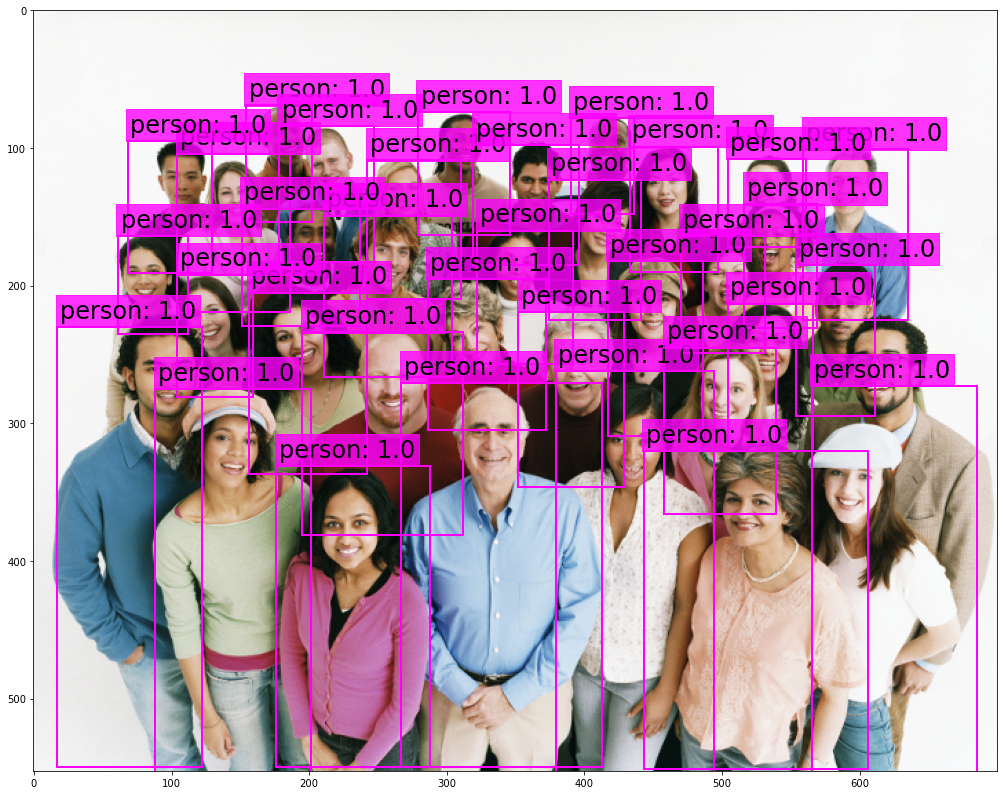

In [26]:
plt.figure(figsize=(24,14))
plt.rcParams['figure.figsize'] = [24.0, 14.0]

Image = cv2.imread(IMAGE_PATH)

orig = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)
resize = cv2.resize(orig, (Model.width, Model.height))

IOU_Threshold = 0.4
NMS_Threshold = 0.6

BOXES = Detection(Model, resize, IOU_Threshold, NMS_Threshold)

print_objects(BOXES, Classes)
plot_boxes(orig, BOXES, Classes, plot_labels = True)

